# Create SAS Viya Model by Importing Open-Source ONNX Model using SAS DLPy

This notebook example creates a SAS Viya ResNet50v1 image classification model by downloading an open-source ResNet50v1 model from the ONNX Model Zoo. Using SAS DLPy, the downloaded ONNX model with weights is imported into the SAS CAS environment and saved as an unweighted SAS Viya ResNet50v1 model. Then DLPy uses the import-generated HDF5 (h5) weights file to create a pre-trained SAS Viya ResNet50v1 image classification model ready for deployment and scoring.

This example uses a ResNet50v1 ONNX library model, but the same approach would be valid for other ONNX model types as well. SAS DLPy currently supports importing models that have the following layer types: Convo, Pool, FC, Batchnorm, Residual, and Concat.

### Contents

* [Important Note: Client and Server Definitions](#ClientServer)
* [Import Python Resources](#ImportPython)
* [Download the Data for this Notebook](#Download)
    * [Download ResNet50v1 Model from ONNX Zoo](#DownloadModel)
    * [Download the Imaginette Score Data](#DownloadData)
* [Connect to SAS CAS](#ConnectCAS)    
* [Load the ONNX Model into SAS CAS](#LoadONNX)
* [Import the ONNX Model into SAS Viya Model](#ImportViya)
* [Load SAS Viya Model Weight](#LoadWeights)
* [Use Weighted SAS Viya ResNet50 Image Classification Model to Score New Data](#ScoreData)

<a id='ClientServer'></a>

### Important Note: Client and Server Definitions
SAS Viya literature and technical documentation often refers to client and server entities. In this scenario, the client is the computer that runs the Jupyter notebook with the example code. The server is the computer that is running the Viya server. These two computers might (or might not) use the same operating system, and might (or might not) have access to a common file system.

This notebook assumes that the client and server do not use the same operating system, but that they do have access to a common file system. If the client and server in your environment do not have access to a common file system, you will need to copy or transfer files between client and server during this example. 

In [1]:
# This code defines path variables that contain path specifications to  
# the client and server machine weight files and image root directories
# You should define ONNX ResNet root directories for client and server environments. 
# Files required by your local notebook enviornment and by the SAS Viya server will go here.


# Server ONNX ResNet root location (your path will be different)
server_onnx_resnet_root = r'/cas/DeepLearn/UserID/ONNX/resnet50v1' #SERVER_ONNX_RESNET_ROOT

# Client ONNX ResNet root location (your path will be different)
client_onnx_resnet_root = r'\\network\root\data\DeepLearn\UserID\ONNX\resnet50v1'  #CLIENT_ONNX_RESNET_ROOT

# The 'server_onnx_resnet_root' and 'client_onnx_resnet_root' path variables 
# are used later in the code to identify locations of required files.

<a id='ImportPython'></a>

### Import Python Resources

In [2]:
# The notebook requires the following Python libraries:
# system and os path commands in code to follow
import sys
import os

# SAS Wrapper for Analytics Transfer (SWAT)
import swat

# SAS DLPy modules
from dlpy import Model
from dlpy.images import ImageTable

# Python ONNX library
import onnx

# Filter unnecessary warnings in notebook
import warnings
warnings.filterwarnings('ignore')

<a id='Download'></a>


### Download the Data for this Notebook

This step of the notebook identifies where all of the model files and data sources that are used in this notebook can be downloaded. Starting the example with all of the required data and model files makes the notebook easier to follow and complete without interruptions.

<a id='DownloadModel'></a>

### Download ResNet50v1 Model from ONNX Zoo

This example begins with a trained ResNet50v1 object detection model downloaded from the open-source [ONNX Model Zoo for Machine Learning](https://github.com/onnx/models). The ONNX Model Zoo data is available for use provided the [copyright and license notices](https://github.com/onnx/models/blob/master/LICENSE) are preserved as specified in the [MIT License].

The ResNet50v1 model used in this notebook can be downloaded from the ONNX Zoo on GitHub [here](https://github.com/onnx/models/blob/master/vision/classification/resnet/model/resnet50-v1.onnx). Save this model to the server-side location you defined in the variable `server_onnx_resnet_root`.

<a id='DownloadData'></a>

### Download the Imaginette Score Data  

This notebook uses one of the 360-px [Imagenette](https://github.com/fastai/imagenette) test data sets to validate the model's functionality. Imaginette is a freely-available subset of 10 easily classified objects derived from the [Imagenet](http://image-net.org/about-overview) library. Imaginette is  provided by [Jeremy Howard](https://www.fast.ai/about/).    

Before downloading the data, create a folder named `Imagenette` at the server-side path specified in your `server_onnx_resnet_root` variable. Extract the `Val` folder from the [imagenette2-320 archive file](https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz) and place it the newly created `server_onnx_resnet_root'/Imagenette` folder. (You should also always extract the [README](https://github.com/fastai/imagenette/blob/master/README.md) and [LICENSE](https://github.com/fastai/imagenette/blob/master/LICENSE) files for usage information.)

The extracted `Val` folder should contain 10 subfolders. Each subfolder contains images for one object class. The ten image classes are tench fish, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, and parachute. 
 
The expanded content in `server_onnx_resnet_root/Imagenette/Val`should have the following structure. The subfolder names might vary and do not reflect the image contents.

* `Val`
    * n01440764
        * (images)       
    * n02102040
        * (images)
    * ...
    * ...
    * n03445777
        * (images)
    * n03888257
        * (images)

<b>Note:</b>This notebook only uses content from the `Val` folder of the Imaginette2-320 archive. However, other SAS Viya ONNX notebook examples use both the `Train` and `Val` folders. You might want to also extract the labeled images in the `Train` folder for other SAS example notebooks, or for your own experimental use. 



<a id="ConnectCAS"></a>


### Connect to SAS CAS

The following code configures your SAS Cloud Analytic Services (CAS) session. SAS CAS is the cloud-based run-time environment for data management and analytics in SAS Viya. 

You need the SAS Statistical Wrapper for Analytics Transfer (SWAT) package to connect to SAS CAS. SWAT is a Python interface to SAS CAS that enables you to load data into memory and apply CAS actions to the data.

Note: For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

In [3]:
# s = swat.CAS(cashost, casport) 
# Your server and port will be different than the one shown.

s = swat.CAS('server.unx.company.com', 5570)

<a id="LoadONNX"></a>

### Load the ONNX Model into SAS CAS

Now load the ONNX ResNet50v1 model `resnet50-v1` into SAS CAS. Point to the client-side path that you saved earlier in the variable `client_onnx_resnet_root`.  

In [4]:
onnx_model = onnx.load_model(client_onnx_resnet_root+'\\resnet50-v1.onnx')

<a id='ImportViya'></a>

### Import ONNX Model into SAS Viya Environment

Now import the ONNX model that you loaded into SAS CAS as a SAS Viya model. The `from_onnx_model()` function provides scale and offset preprocessing parameter values used for model training, and creates a SAS Viya model named `model1`.

In [5]:
model1 = Model.from_onnx_model(s, 
                               onnx_model,
                               output_model_table='resnet50v1',
                               scale=0.0173611, 
                               offsets=[2.155, 2.027, 1.804])

NOTE: Successfully written weights file as C:\Users\UserID\onnx\resnet50v1_weights.onnxmodel.h5
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50v1" according to the model name in the table.
NOTE: Successfully imported ONNX model.


If the code runs successfully, the output should begin by specifying the location of the model weights file in a statement similar to the following:

`NOTE: Successfully written weights file as C:\Users\UserID\onnx\resnet50v1_weights.onnxmodel.h5`

You should copy the `resnet50v1_weights.onnxmodel.h5` file to the location that you specified in the path variable `server_onnx_resnet_root`. You will use this file when you load model weights in the next section.

Now you can use the SAS DLPy `print_summary()` function to display the unweighted SAS Viya ResNet50v1 model structure:

In [6]:
model1.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,data,input,,,None,"(224, 224, 3)","(0, 0)",0
1,1,resnetv17_conv0_fwd,convo,"(7, 7)","(2.0, 2.0)",Identity,"(112, 112, 64)","(9408, 0)",118013952
2,2,resnetv17_batchnorm0_fwd,batchnorm,,,Rectifier,"(112, 112, 64)","(0, 128)",0
3,3,resnetv17_pool0_fwd,pool,"(3, 3)","(2.0, 2.0)",Max,"(56, 56, 64)","(0, 0)",0
4,4,resnetv17_stage1_conv3_fwd,convo,"(1, 1)","(1.0, 1.0)",Identity,"(56, 56, 256)","(16384, 0)",51380224
...,...,...,...,...,...,...,...,...,...
123,123,resnetv17_stage4__plus2,residual,,,Rectifier,"(7, 7, 2048)","(0, 0)",0
124,124,resnetv17_pool1_fwd,pool,"(7, 7)","(7.0, 7.0)",Mean,"(1, 1, 2048)","(0, 0)",0
125,125,resnetv17_dense0_fwd,output,"(2048, 1000)",,Softmax,1000,"(2048000, 1000)",0
126,,,,,,,,Total number of parameters,Total FLOPS


<a id='LoadWeights'></a>

### Load SAS Viya Model Weights

You now have an unweighted SAS Viya ResNet50v1 image classification model. Next, load the pre-trained model weights HDF5 (.h5) file that was created when you imported the ONNX model into SAS Viya. If you haven't done so, copy the newly output `resnet50v1_weights.onnxmodel.h5` weight file to the server-side location you specified in the variable `server_onnx_resnet_root`. 

In [7]:
# Copy the h5 file to a server side location and
# Specify labels=True to show the imagenet labels

model1.load_weights(server_onnx_resnet_root+'//resnet50v1_weights.onnxmodel.h5', labels=True)

NOTE: Cloud Analytic Services made the uploaded file available as table NEW_LABEL_TABLE_CXIULV in caslib CASUSER(UserID).
NOTE: The table NEW_LABEL_TABLE_CXIULV has been created in caslib CASUSER(UserID) from binary data uploaded to Cloud Analytic Services.
NOTE: no dataspec(s) provided - creating image classification model.
NOTE: Model weights attached successfully!


You now have a trained and weighted SAS Viya ResNet50v1 image classification model named `model1`. This model was created by downloading an open-source ONNX model, importing the ONNX model into a SAS Viya model via SAS DLPy, and then using the generated .h5 file with DLPy to create a pre-trained SAS Viya ResNet50v1 image classification model weighted for ImageNet data.  

<a id='ScoreData'></a>


### Use Weighted SAS Viya ResNet50v1 Image Classification Model to Score New Data

Now submit the test data that you stored in `server_onnx_resnet_root/Imaginette/val` to the SAS Viya ResNet50v1 image classification model for scoring. Then, display random images from the scored test output to view instances of model prediction performance. 

In [8]:
# Load the Imagenette Test images 
img = ImageTable.load_files(s, path=server_onnx_resnet_root+'/Imagenette/val')

The Imagenette images that we are going to score have dimensions as large as 360px, which is larger than the ImageNet standard size. Resize the Imagenette test images so that they conform to the ImageNet standard size of 224px by 224px.

In [9]:
img.resize(224)

Now use the DLPy function `evaluate()` with the new ResNet50v1 image classification model j`model1` to score the new data. Then use the DLPy `plot_evaluate_res()` function to display plots of random classification predictions from the scored Test data in `Imagenette/val/`:

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(UserID).


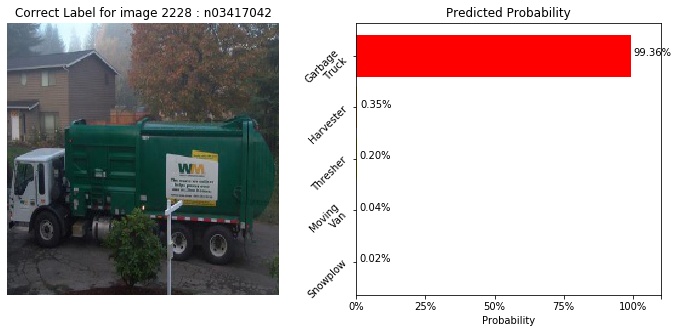

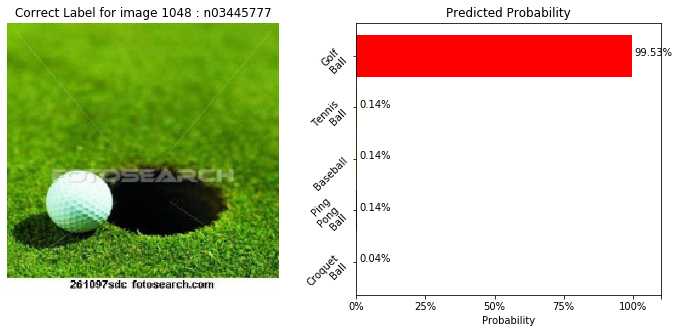

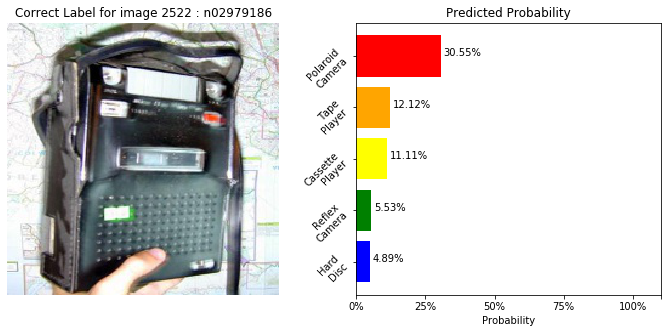

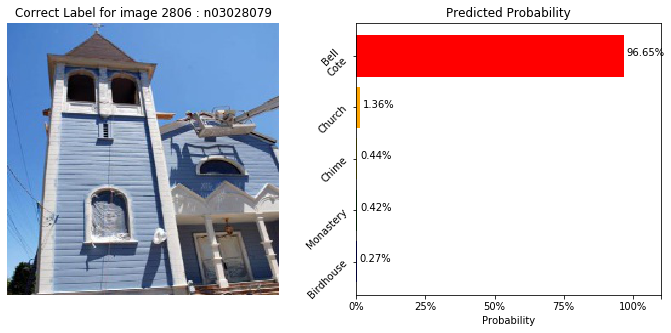

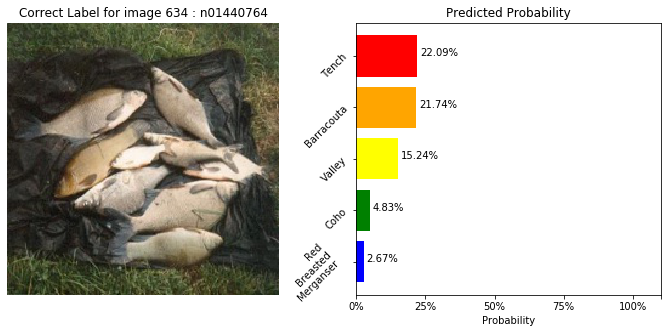

In [10]:
model1.evaluate(img)
model1.plot_evaluate_res(randomize=True)

In [ ]:
s.endsession()